# Detect Court and Basket

The primary objective of this notebook is to detect the basketball court lines and basketball hoop.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plt_img(img):
    im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (15,8))
    plt.imshow(im)
    plt.xticks([]), plt.yticks([])
    plt.show()

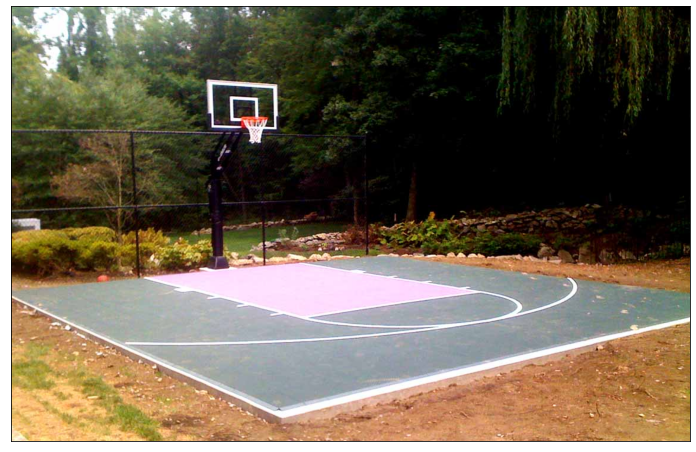

In [3]:
img = cv2.imread('../data/notebook_test_data/test3.jpg')
plt_img(img)

I chose this online picture because the edges are distinctly different colors. \
I want to see if I can use **homography** to map the court edges and court lines onto a 2-D coordinate system. \
A problem I can see right away is not all camera shots will capture the entire court. One corner of this court is cut off as shown in the picture. I need to extrapolate these cut-off pieces of the court.

Our app will expect a still camera shot, so the position of the court will not change throughout the video. Hence, using homography is appropriate and easier than other more advanced methods like the one mentioned here:
https://people.cs.nctu.edu.tw/~yushuen/data/BasketballVideo15.pdf

# 1. Find Court Corners

In [4]:
def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDBLCLK:
        cv2.circle(img,(x,y),100,(255,0,0),-1)
        mouseX,mouseY = x,y

In [5]:
cv2.namedWindow('locate_points')
cv2.setMouseCallback('locate_points',draw_circle)

In [ ]:
while(1):
    cv2.imshow('image',img)
    k = cv2.waitKey(20) & 0xFF
    if k == 27:
        break
    elif k == ord('a'):
        print(mouseX,mouseY)

# 2. Apply Simple Homography

Homography is the practice of using a transformation matrix to match a set of points on one plane to another desired plane.


In [ ]:
pts_src = np.array([[1, 486],
                    [455, 684],
                    [1213, 513],
                    [630, 425]])

In [ ]:
pts_dst = np.array([[0, 0],
                    [0, 500],
                    [800, 500],
                    [800, 0]])

In [ ]:
# Calculate Homography
h, status = cv2.findHomography(pts_src, pts_dst)

In [ ]:
img_dst = np.zeros((500,800,3), np.uint8)

In [ ]:
# Warp source image to destination based on homography
img_out = cv2.warpPerspective(img, h, (img_dst.shape[1], img_dst.shape[0]))
plt_img(img_out)

It seems hard to map the court exactly to a 2d coordinate system. The missing corner makes it hard to extrapolate the last corner and thus the image seems distorted.

In [ ]:
img = cv2.imread('../data/notebook_test_data/test4.jpg')
plt_img(img)

In [ ]:
pts_src = np.array([[137, 276],
                    [2, 337],
                    [561, 340],
                    [432, 277]])

pts_dst = np.array([[0, 0],
                    [0, 500],
                    [800, 500],
                    [800, 0]])


# Calculate Homography
h, status = cv2.findHomography(pts_src, pts_dst)

img_dst = np.zeros((500,800,3), np.uint8)

# Warp source image to destination based on homography
img_out = cv2.warpPerspective(img, h, (img_dst.shape[1], img_dst.shape[0]))
plt_img(img_out)

The idea of using homography to map court to 2d plot seems to work.

The next step is to use techniques to segment court.

# 3. Use Line Detection

https://stackoverflow.com/questions/45322630/how-to-detect-lines-in-opencv

In [ ]:
img = cv2.imread('../data/notebook_test_data/test4.jpg')
plt_img(img)

In [ ]:
# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# gaussian blur
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

In [ ]:
# canny edge detector
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

In [ ]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

In [ ]:
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

In [ ]:
plt_img(lines_edges)

# 4. Panoptic Segmentation to find Court

In [ ]:
img = cv2.imread('../data/notebook_test_data/test3.jpg')
plt_img(img)

In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
cfg = get_cfg()

# mac's do not have CUDA support, run on CPU
cfg.MODEL.DEVICE = "cpu"

# get pretrained model
config_file = "COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_file))

# model weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)

# set some model specific hyperparameters
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # only post-process ROI heads with score > value


In [ ]:
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

In [ ]:
panoptic_seg, segments_info = outputs["panoptic_seg"]

In [ ]:
# convert from openCV BGR format to RGB format
im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

v = Visualizer(im, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)

plt.figure(figsize = (15,8))
plt.xticks([]), plt.yticks([])
plt.imshow(out.get_image())